# Non-local, frame-independent data-driven modeling

## Transport PDE
The transport equation (or convection-diffusion equation) for scalar quantity is given as:
$$
\frac{\partial c}{\partial t} = - \mathbf{v}\cdot\nabla c +  \nabla\cdot(D \nabla c) + \mathbf{S}(x) - \zeta c
$$

where c represents the scalar quantity (i.e. temperature or chemical concentraion), $\mathbf{v}$ represents velocity vector, $D$ represents the diffusion coefficient, $\mathbf{S}$ represents the production source of the quantity c and $\zeta$ represents the dissipation coefficient. For the consideration of steady problem, term on left hand side becomes zero.

In [1]:
%matplotlib inline

# system modules
import os
import time
from pathlib import Path
from IPython.display import display, Math

# scientific computing
import numpy as np
from numpy import linalg as LA
import pandas as pd
np.random.seed(42)
from fipy import CellVariable, FaceVariable, Grid2D
from fipy import DiffusionTerm, ExponentialConvectionTerm, DefaultAsymmetricSolver, ImplicitSourceTerm
from fipy import MatplotlibStreamViewer
from fipy.tools.numerix import array, reshape

# plotting
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
import plotly.io as pio
from plotly import subplots
init_notebook_mode(connected=True)

# pytorch importing
import torch
import torch.nn as nn
from torchvision import datasets
from torch.optim import lr_scheduler, Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
torch.manual_seed(42)

### Gaussian Process

In [2]:
def GP_source(mesh_src):
    
    # hyperparameters
    sigma = 1; l1 = 0.02; l2 = 0.02
    
    # source mesh points
    src_xy = mesh_src.cellCenters.value
    
    # rbf_kernel (create a specified covariance matrix)
    '''
            rbf_kernel:  sigma**2 exp(-(|x_i - x_j|)**2 / (2*l**2))
    '''
    cov = np.zeros([Nx*Ny,Nx*Ny])
    for j in range(Nx*Ny):
        for i in range(Nx*Ny):
            cov[i,j] = sigma**2 * np.exp(-((src_xy[0,i]-src_xy[0,j])**2 / (2*l1**2) + (src_xy[1,i]-src_xy[1,j])**2 / (2*l2**2)))

    # Make sure covariance matrix is symmetric
    a = np.allclose(cov, cov.T, rtol=1e-05, atol=1e-08)
    
    cov = cov + 1e-10*np.eye(np.shape(cov)[0])
    # Make sure your matrix is positve definite
    b = np.any(np.linalg.eigvalsh(cov) < 0.)
    
    if a==False:
        print('ERROR: Covariance matrix is not symmetric as required')
    elif b==True:
        print('ERROR: Covariance matrix is not positive definite as required')
        print('eigenvalues: ', np.linalg.eigvalsh(cov))

    # Decompose covariance matrix (Cholesky Decomposition)
    L = np.linalg.cholesky(cov)
    Lt = L.T
    L_Lt = np.dot(L,Lt)

    a = np.allclose(cov, L_Lt, rtol=1e-05, atol=1e-08)
#     if a==True:
#         print('Successfully decomposed!')
#     else:
#         print('ERROR: L_Lt != cov')
    
    # generate uncorrelated standard normal
    u = np.random.normal(size=(Nx*Ny,1))

    # generate samples，do scaling and reshape
    samples = np.dot(L,u)
    samples_true = (5/(samples.max()-samples.min()))*(samples-samples.min())+0
    samples_source = samples_true.reshape(Ny,Nx)
    
    return samples_source

### Source Function

In [3]:
def sample_src(mesh):
    src = CellVariable(name='Source', mesh=mesh)   
    c_xy = mesh.cellCenters.value
    
    # reshape src
    src_matrix = src.value.reshape(ny,nx)
    src_matrix[int((ny-Ny)/2):int((ny+Ny)/2),int((nx-Nx)/2):int((nx+Nx)/2)] = GP_source(mesh_src)
    src.value = src_matrix.flatten()
    
    return src

### Velocity Function
At any given point, velocity is given as:
$$ u = C_u cos\alpha $$
$$ v = C_u sin\alpha $$
where 

$C_u$ is the strength of uniform flow,

$\alpha$ is the angle of uniform flow,

In [4]:
def sample_vel(mesh, C_u, alpha):
    vel = mesh.cellCenters.copy()
    vel.name = 'Velocity'
    vel.value[0] = C_u * np.cos(alpha)
    vel.value[1] = C_u * np.sin(alpha)
    return vel

### Data Generation Function

In [5]:
def sample_data(mesh, C_uniform, alpha, diff_coeff, diss_coeff):
    data_list = []
    array_list = []
    var = CellVariable(name='Variable',mesh=mesh)
    src = sample_src(mesh)
    var.constrain(0, mesh.facesLeft)
    var.constrain(0, mesh.facesRight)
    var.constrain(0, mesh.facesTop)
    var.constrain(0, mesh.facesBottom)
    vel = sample_vel(mesh, C_uniform, alpha)
    eq = - ExponentialConvectionTerm(coeff=vel) + DiffusionTerm(coeff=diff_coeff) - ImplicitSourceTerm(diss_coeff) + src
    eq.solve(var=var, solver=DefaultAsymmetricSolver(tolerance=1.e-12, iterations=10000))
    data = {'var': var, 'src': src, 'vel': vel, 'diff': diff_coeff, 'diss': diss_coeff}
    return data

### Neural Network Model

In [6]:
class CNN_Network(nn.Module):
    def __init__(self, dimensions, num_layers):
        super(CNN_Network, self).__init__()
        
        self.dimensions = dimensions
        self.layers = nn.ModuleList()
        self.relu = nn.ReLU()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=36, kernel_size=3, stride=1)
#         nn.init.xavier_normal_(self.conv1.weight)
#         self.conv2 = nn.Conv2d(in_channels=36, out_channels=36, kernel_size=3, stride=1)
#         nn.init.xavier_normal_(self.conv2.weight)
        self.conv3 = nn.Conv2d(in_channels=36, out_channels=24, kernel_size=3, stride=1)
#         nn.init.xavier_normal_(self.conv3.weight)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=12, kernel_size=3, stride=1)
#         self.conv5 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1)
        self.conv6 = nn.Conv2d(in_channels=12, out_channels=4, kernel_size=3, stride=1)
#         nn.init.xavier_normal_(self.conv4.weight)
        
        for k in range(num_layers):
            self.layers.append(nn.Linear(self.dimensions[k], self.dimensions[k+1]))
#             nn.init.xavier_normal_(self.layers[k].weight)
        self.layers.append(nn.Linear(self.dimensions[num_layers], self.dimensions[-1]))
#         nn.init.xavier_normal_(self.layers[num_layers].weight)
        
    def forward(self, X):
        out = self.relu(self.conv1(X))
#         out = self.relu(self.conv2(out))
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
#         out = self.relu(self.conv5(out))
        out = self.conv6(out)
        out = out.view(-1, 4*3*3)
        for i in range(len(self.layers)-1):
            out = self.layers[i](out)
            out = self.relu(out)
        out = self.layers[-1](out)
        return out

### Training Function

In [7]:
def train(train_loader, valid_loader, num_epoch):
    train_err_hist = torch.cuda.FloatTensor(1,1).fill_(0)
    valid_err_hist = torch.cuda.FloatTensor(1,1).fill_(0)
    train_loss_hist = torch.cuda.FloatTensor(1,1).fill_(0)
    valid_loss_hist = torch.cuda.FloatTensor(1,1).fill_(0)

    for epoch in range(num_epoch+1):
        train_loss_array = torch.cuda.FloatTensor(1,1).fill_(0)
        train_err_rate_num = torch.cuda.FloatTensor(1,1).fill_(0)
        train_err_rate_den = torch.cuda.FloatTensor(1,1).fill_(0)
        valid_loss_array = torch.cuda.FloatTensor(1,1).fill_(0)
        valid_err_rate_num = torch.cuda.FloatTensor(1,1).fill_(0)
        valid_err_rate_den = torch.cuda.FloatTensor(1,1).fill_(0)

        for i, data in enumerate(train_loader):
            features, target = data
            optimizer.zero_grad()
            forward = model(features)
            loss = loss_fn(forward, target)
            loss.backward()
            optimizer.step()

            train_loss_array = torch.cat((train_loss_array, torch.cuda.FloatTensor([[loss.item()]])))
            train_err_num, train_err_den = report_err_rate(target, forward)
            train_err_rate_num = torch.cat((train_err_rate_num, (train_err_num.view(1,-1))**2), 0)
            train_err_rate_den = torch.cat((train_err_rate_den, (train_err_den.view(1,-1))**2), 0)

        train_loss = torch.mean(train_loss_array)
        train_err_rate = 100*((torch.sum(train_err_rate_num, 0))**0.5)/((torch.sum(train_err_rate_den, 0))**0.5)

        exp_lr_scheduler.step()

        with torch.no_grad():
            for i, data_valid in enumerate(valid_loader):
                features_valid, target_valid = data_valid
                forward_valid = model(features_valid)
                pred_loss = loss_fn(forward_valid, target_valid)

                valid_loss_array = torch.cat((valid_loss_array, torch.cuda.FloatTensor([[loss.item()]])))
                valid_err_num, valid_err_den = report_err_rate(target_valid, forward_valid)
                valid_err_rate_num = torch.cat((valid_err_rate_num, (valid_err_num.view(1,-1))**2), 0)
                valid_err_rate_den = torch.cat((valid_err_rate_den, (valid_err_den.view(1,-1))**2), 0)

            valid_loss = torch.mean(valid_loss_array)
            valid_err_rate = 100*((torch.sum(valid_err_rate_num, 0))**0.5)/((torch.sum(valid_err_rate_den, 0))**0.5)

        verb = True if (epoch >= 50) and (epoch % 10 == 0) else False
        if (verb):
            train_loss_hist = torch.cat((train_loss_hist, torch.cuda.FloatTensor([[train_loss]])))
            train_err_hist = torch.cat((train_err_hist, train_err_rate.view(1,-1)), 0)
            valid_loss_hist = torch.cat((valid_loss_hist, torch.cuda.FloatTensor([[valid_loss]])))
            valid_err_hist = torch.cat((valid_err_hist, valid_err_rate.view(1,-1)), 0)
        verb = True if (epoch % 50 == 0) else False
        if (verb) :
            print('{:4}   lr: {:.2e}   train_loss: {:.2e}   valid_loss: {:.2e}   train_error:{:7.2f}%   valid_error:{:7.2f}%' \
                  .format(epoch, exp_lr_scheduler.get_lr()[0], train_loss, valid_loss, train_err_rate[0], valid_err_rate[0]))

    print('Finished Training')
    return train_loss_hist, train_err_hist, valid_loss_hist, valid_err_hist

In [8]:
def report_err_rate(target, forward):
    errRate_sigma_num = torch.norm(forward - target, dim = 0)
    errRate_sigma_den = torch.norm(target, dim = 0)
    return errRate_sigma_num, errRate_sigma_den

### Plotting Functions

In [9]:
def error_plot(training_loss_history, training_error_history, valid_loss_history, valid_error_history):
    
    data1 = go.Scatter(x=np.arange(50,num_epoch+1,10), y=training_loss_history[1:,0], line = dict(width=1.7), name = 'Training Loss', mode = 'lines')
    data2 = go.Scatter(x=np.arange(50,num_epoch+1,10), y=valid_loss_history[1:,0], line = dict(width=1.7), name = 'Validation Loss', mode = 'lines')
    data3 = go.Scatter(x=np.arange(50,num_epoch+1,10), y=training_error_history[1:,0], line = dict(width=1.7), name = 'Training Error', mode = 'lines')
    data4 = go.Scatter(x=np.arange(50,num_epoch+1,10), y=valid_error_history[1:,0], line = dict(width=1.7), name = 'Validation Error', mode = 'lines')
    
    fig = subplots.make_subplots(rows=1, cols=2)
    fig.append_trace(data1, 1, 1)
    fig.append_trace(data2, 1, 1)
    fig.append_trace(data3, 1, 2)
    fig.append_trace(data4, 1, 2)
    
    fig['layout']['xaxis1'].update(title='Epochs', showgrid=True, gridwidth=0.5, gridcolor='lightgrey', showline=True, linecolor='black')
    fig['layout']['yaxis1'].update(title='Loss', showgrid=True, gridwidth=0.5, gridcolor='lightgrey', showline=True, linecolor='black')
    fig['layout']['xaxis2'].update(title='Epochs', showgrid=True, gridwidth=0.5, gridcolor='lightgrey', showline=True, linecolor='black')
    fig['layout']['yaxis2'].update(title='Error %', showgrid=True, gridwidth=0.5, gridcolor='lightgrey', showline=True, linecolor='black')
    fig['layout'].update(height=450, width=1000, plot_bgcolor = 'rgba(0,0,0,0)', title='Loss and Error Percentage History')
    iplot(fig)

In [10]:
def plot_valid(nn_target,nn_output, title):

    data1 = go.Scatter(x=nn_target[:,0].numpy(), y=nn_output[:,0].numpy(), mode='markers', 
                       marker=dict(color='rgb(158, 22, 25)', size=7, opacity=0.3,
                                     line=dict(width=1)), showlegend=True , name='NN')
    
    line_min = np.array([nn_target[:,0].numpy().min(), nn_output[:,0].numpy().min()]).min()
    line_max = np.array([nn_target[:,0].numpy().max(), nn_output[:,0].numpy().max()]).max()
    data2 = go.Scatter(x=np.linspace(line_min,line_max,10), y=np.linspace(line_min,line_max, 10), mode='lines', 
                       line=dict(width=1.7, color='black'), showlegend=False)

    layout = go.Layout(title=title, 
                       xaxis=dict(title='Truth', range=[line_min, line_max], showgrid=False, showline=True, linecolor='black', zeroline=False, mirror='ticks'),
                       yaxis=dict(title='Prediction', range=[line_min, line_max], showgrid=False, showline=True, linecolor='black', zeroline=False, mirror='ticks'),
                       width=600, height=570, plot_bgcolor = 'rgba(0,0,0,0)')
    
    fig = go.Figure(data=[data1,data2], layout=layout)
    iplot(fig)

In [11]:
def view_cell(var, x_box, y_box):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))
    axes.set_title('{}'.format(var.name))
    axes.set_xlabel('x')
    axes.set_ylabel('y')
    cmap = matplotlib.cm.jet
    xmin, ymin = var.mesh.extents['min']
    xmax, ymax = var.mesh.extents['max']
    data = reshape(array(var), var.mesh.shape[::-1])[::-1]
    img = axes.imshow(data, extent=(xmin, xmax, ymin, ymax), cmap=cmap)
    axes.plot(x_box,y_box,color='white',linewidth=2)
    plt.colorbar(img)

### Domain Specification

In [12]:
if torch.cuda.is_available():
    device=torch.device('cuda:0')
else:
    device=torch.device('cpu')

device_cpu = torch.device('cpu')

In [13]:
Lx = 5
Ly = 3
nx = Lx*100
ny = Ly*100
mesh = Grid2D(dx=Lx/nx, dy=Ly/ny, nx=nx, ny=ny)
dx=Lx/nx;dy=Ly/ny

# Inner source field 
Nx = 60; Ny = 36
mesh_src = Grid2D(dx, dy, nx=Nx, ny=Ny)

# point 1,2,3,4 represent the left_up, right_up, right_down, left_down points of the source
x1 = Lx/2 - dx * (Nx/2 - 0.5); y1 = Ly/2 + dy * (Ny/2 - 0.5)
x2 = Lx/2 + dx * (Nx/2 - 0.5); y4 = Ly/2 - dy * (Ny/2 - 0.5)
x4 = x1; x3 = x2; y2 = y1; y3 = y4

In [14]:
epsilon=2e-1
n=4
cells=np.array([[-5,-4,-3,-2,-1,0,1,2,3,4,5]])
cells_x=np.repeat(cells,cells.shape[1],axis=0)
cells_y=np.repeat(cells.T,cells.shape[1],axis=1)

In [15]:
num_layers = 7   #number of hidden layers
dimensions = [36, 96*2, 96*2, 96*2, 96*2, 96*2, 96*2, 96*2, 96*2, 96*2, 96*2, 1] #neurons in each layer

## Case 3a: Training and Validation data from different flow cases

### Data Generation - Validation

diff     diss     U           h_1     h_2    w_1_2
0.044   14.754   1.598        0.211   0.036    0.088


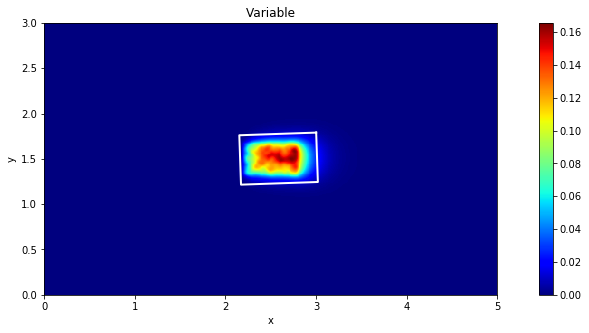

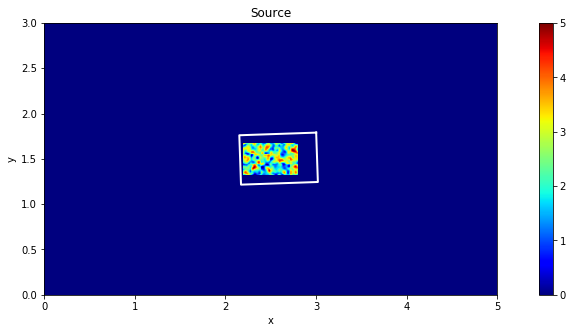

In [16]:
num_samples_valid=1
print('diff     diss     U           h_1     h_2    w_1_2')

for sample in range(num_samples_valid):
    # PDE coefficients
    diff_coeff = np.random.uniform(low=0.01, high=0.1)     # Diffusion Coefficient
    diss_coeff = np.random.uniform(low=10, high=15)     # Dissipation Coefficient
    
    # flow parameters
    C_uniform = np.random.uniform(low=0.5, high=2)     # Uniform Flow Strength
    alpha = np.random.uniform(low=-10*np.pi/180, high=10*np.pi/180)     # Uniform Flow Angle
    
    data_3_valid = sample_data(mesh, C_uniform, alpha, diff_coeff, diss_coeff)
    
    lambda1=(C_uniform - (((C_uniform**2)+(4*diff_coeff*diss_coeff))**0.5)) / (2*diff_coeff)
    lambda2=(C_uniform + (((C_uniform**2)+(4*diff_coeff*diss_coeff))**0.5)) / (2*diff_coeff)
    h_1=np.abs(np.log(epsilon)/lambda1)
    h_2=np.abs(np.log(epsilon)/lambda2)
    w_1_2 = np.sqrt(diff_coeff/diss_coeff)*np.abs(np.log(epsilon))
    
    if alpha <= 0:
        right_up=np.array([[x2+(h_1+(y2-y3)*np.sin(-alpha))*np.cos(-alpha)+w_1_2*np.sin(-alpha)],[y2-(h_1+(y2-y3)*np.sin(-alpha))*np.sin(-alpha)+w_1_2*np.cos(-alpha)]])
        right_down=np.array([[x3+h_1*np.cos(-alpha)-(w_1_2+(x3-x4)*np.sin(-alpha))*np.sin(-alpha)],[y3-h_1*np.sin(-alpha)-(w_1_2+(x3-x4)*np.sin(-alpha))*np.cos(-alpha)]])
        left_up=np.array([[x1-h_2*np.cos(-alpha)+((x2-x1)*np.sin(-alpha)+w_1_2)*np.sin(-alpha)],[y1+h_2*np.sin(-alpha)+((x2-x1)*np.sin(-alpha)+w_1_2)*np.cos(-alpha)]])
        left_down=np.array([[x4-(h_2+(y1-y4)*np.sin(-alpha))*np.cos(-alpha)-w_1_2*np.sin(-alpha)],[y4+(h_2+(y1-y4)*np.sin(-alpha))*np.sin(-alpha)-w_1_2*np.cos(-alpha)]])
    else:
        right_up=np.array([[x2+h_1*np.cos(alpha)-(w_1_2+(x2-x1)*np.sin(alpha))*np.sin(alpha)],[y2+h_1*np.sin(alpha)+(w_1_2+(x2-x1)*np.sin(alpha))*np.cos(alpha)]])
        right_down=np.array([[x3+(h_1+(y2-y3)*np.sin(alpha))*np.cos(alpha)+w_1_2*np.sin(alpha)],[y3+(h_1+(y2-y3)*np.sin(alpha))*np.sin(alpha)-w_1_2*np.cos(alpha)]])
        left_up=np.array([[x1-(h_2+(y1-y4)*np.sin(alpha))*np.cos(alpha)-w_1_2*np.sin(alpha)],[y1-(h_2+(y1-y4)*np.sin(alpha))*np.sin(alpha)+w_1_2*np.cos(alpha)]])
        left_down=np.array([[x4-h_2*np.cos(alpha)+(w_1_2+(x3-x4)*np.sin(alpha))*np.sin(alpha)],[y4-h_2*np.sin(alpha)-(w_1_2+(x3-x4)*np.sin(alpha))*np.cos(alpha)]])
    
    x_box=np.array([right_up[0,0],right_down[0,0],left_down[0,0],left_up[0,0],right_up[0,0]])
    y_box=np.array([right_up[1,0],right_down[1,0],left_down[1,0],left_up[1,0],right_up[1,0]])
    
    print('{:.3f}   {:.3f}   {:.3f}        {:.3f}   {:.3f}    {:.3f}'.format(diff_coeff,diss_coeff,C_uniform,h_1,h_2,w_1_2))
    view_cell(data_3_valid['var'], x_box, y_box)
    view_cell(data_3_valid['src'], x_box, y_box)
    
    c_data_valid_mesh_3 = reshape(array(data_3_valid['var']), data_3_valid['var'].mesh.shape[::-1])
    s_data_valid_mesh_3 = reshape(array(data_3_valid['src']), data_3_valid['src'].mesh.shape[::-1])
    u_data_valid_mesh_3 = reshape(array(data_3_valid['vel'])[0,:], data_3_valid['vel'].mesh.shape[::-1])
    v_data_valid_mesh_3 = reshape(array(data_3_valid['vel'])[1,:], data_3_valid['vel'].mesh.shape[::-1])
    
    x_box=np.around(x_box*100)
    y_box=np.around(y_box*100)
    x_inc=np.array([np.around(np.linspace(x_box[0],x_box[1],np.abs(y_box[3]-y_box[2])))]) -x_box[0]
    y_inc=np.array([np.around(np.linspace(y_box[-2],y_box[-1],np.abs(x_box[-1]-x_box[-2])))]) -y_box[-2]

    x_seq=np.array([np.arange(x_box[-2],x_box[-1],1)])
    y_seq=np.array([np.arange(y_box[3],y_box[2],-1)])
    
    x_mat = (np.repeat(x_seq,y_seq.shape[1],axis=0) + np.repeat(x_inc.T,y_inc.shape[1],axis=1)).astype(int)
    y_mat = (np.repeat(y_seq.T,x_seq.shape[1],axis=1) + np.repeat(y_inc,x_inc.shape[1],axis=0)).astype(int)
    
    c_data_box=c_data_valid_mesh_3[y_mat,x_mat]
    
    dataX_valid_current=np.empty([c_data_box.shape[0]*c_data_box.shape[1], 3, cells.shape[1], cells.shape[1]])
    dataY_valid_current=np.empty([c_data_box.shape[0]*c_data_box.shape[1], 1])
    
    data_ind=0
    for i in range(c_data_box.shape[0]):
        for j in range(c_data_box.shape[1]):
            dataX_valid_current[data_ind,0,:,:]=u_data_valid_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataX_valid_current[data_ind,1,:,:]=v_data_valid_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataX_valid_current[data_ind,2,:,:]=s_data_valid_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataY_valid_current[data_ind,0]=c_data_box[i,j]
            data_ind+=1
    
    dataX_valid_current=torch.tensor(dataX_valid_current).to(dtype=torch.float)
    dataY_valid_current=torch.tensor(dataY_valid_current).to(dtype=torch.float)
    
    if sample<1:
        dataX_valid=dataX_valid_current
        dataY_valid=dataY_valid_current
    else:
        dataX_valid=torch.cat((dataX_valid,dataX_valid_current))
        dataY_valid=torch.cat((dataY_valid,dataY_valid_current))

### Data Generation - Training

In [17]:
num_samples=5
for sample in range(num_samples):
    # PDE coefficients
    diff_coeff = np.random.uniform(low=0.01, high=0.1)     # Diffusion Coefficient
    diss_coeff = np.random.uniform(low=10, high=15)     # Dissipation Coefficient
    
    # flow parameters
    C_uniform = np.random.uniform(low=0.5, high=2)     # Uniform Flow Strength
    alpha = np.random.uniform(low=-10*np.pi/180, high=10*np.pi/180)     # Uniform Flow Angle

    data_3 = sample_data(mesh, C_uniform, alpha, diff_coeff, diss_coeff)
    
    lambda1=(C_uniform - (((C_uniform**2)+(4*diff_coeff*diss_coeff))**0.5)) / (2*diff_coeff)
    lambda2=(C_uniform + (((C_uniform**2)+(4*diff_coeff*diss_coeff))**0.5)) / (2*diff_coeff)
    h_1=np.abs(np.log(epsilon)/lambda1)
    h_2=np.abs(np.log(epsilon)/lambda2)
    w_1_2 = np.sqrt(diff_coeff/diss_coeff)*np.abs(np.log(epsilon))

    if alpha <= 0:
        right_up=np.array([[x2+(h_1+(y2-y3)*np.sin(-alpha))*np.cos(-alpha)+w_1_2*np.sin(-alpha)],[y2-(h_1+(y2-y3)*np.sin(-alpha))*np.sin(-alpha)+w_1_2*np.cos(-alpha)]])
        right_down=np.array([[x3+h_1*np.cos(-alpha)-(w_1_2+(x3-x4)*np.sin(-alpha))*np.sin(-alpha)],[y3-h_1*np.sin(-alpha)-(w_1_2+(x3-x4)*np.sin(-alpha))*np.cos(-alpha)]])
        left_up=np.array([[x1-h_2*np.cos(-alpha)+((x2-x1)*np.sin(-alpha)+w_1_2)*np.sin(-alpha)],[y1+h_2*np.sin(-alpha)+((x2-x1)*np.sin(-alpha)+w_1_2)*np.cos(-alpha)]])
        left_down=np.array([[x4-(h_2+(y1-y4)*np.sin(-alpha))*np.cos(-alpha)-w_1_2*np.sin(-alpha)],[y4+(h_2+(y1-y4)*np.sin(-alpha))*np.sin(-alpha)-w_1_2*np.cos(-alpha)]])
    else:
        right_up=np.array([[x2+h_1*np.cos(alpha)-(w_1_2+(x2-x1)*np.sin(alpha))*np.sin(alpha)],[y2+h_1*np.sin(alpha)+(w_1_2+(x2-x1)*np.sin(alpha))*np.cos(alpha)]])
        right_down=np.array([[x3+(h_1+(y2-y3)*np.sin(alpha))*np.cos(alpha)+w_1_2*np.sin(alpha)],[y3+(h_1+(y2-y3)*np.sin(alpha))*np.sin(alpha)-w_1_2*np.cos(alpha)]])
        left_up=np.array([[x1-(h_2+(y1-y4)*np.sin(alpha))*np.cos(alpha)-w_1_2*np.sin(alpha)],[y1-(h_2+(y1-y4)*np.sin(alpha))*np.sin(alpha)+w_1_2*np.cos(alpha)]])
        left_down=np.array([[x4-h_2*np.cos(alpha)+(w_1_2+(x3-x4)*np.sin(alpha))*np.sin(alpha)],[y4-h_2*np.sin(alpha)-(w_1_2+(x3-x4)*np.sin(alpha))*np.cos(alpha)]])
    
    x_box=np.array([right_up[0,0],right_down[0,0],left_down[0,0],left_up[0,0],right_up[0,0]])
    y_box=np.array([right_up[1,0],right_down[1,0],left_down[1,0],left_up[1,0],right_up[1,0]])
    
    
#     view_cell(data_3['var'], x_box, y_box)
#     view_cell(data_3['src'], x_box, y_box)
    
    c_data_mesh_3 = reshape(array(data_3['var']), data_3['var'].mesh.shape[::-1])
    s_data_mesh_3 = reshape(array(data_3['src']), data_3['src'].mesh.shape[::-1])
    u_data_mesh_3 = reshape(array(data_3['vel'])[0,:], data_3['vel'].mesh.shape[::-1])
    v_data_mesh_3 = reshape(array(data_3['vel'])[1,:], data_3['vel'].mesh.shape[::-1])
    
    x_box=np.around(x_box*100)
    y_box=np.around(y_box*100)
    x_inc=np.array([np.around(np.linspace(x_box[0],x_box[1],np.abs(y_box[3]-y_box[2])))]) -x_box[0]
    y_inc=np.array([np.around(np.linspace(y_box[-2],y_box[-1],np.abs(x_box[-1]-x_box[-2])))]) -y_box[-2]

    x_seq=np.array([np.arange(x_box[-2],x_box[-1],1)])
    y_seq=np.array([np.arange(y_box[3],y_box[2],-1)])
    
    x_mat = (np.repeat(x_seq,y_seq.shape[1],axis=0) + np.repeat(x_inc.T,y_inc.shape[1],axis=1)).astype(int)
    y_mat = (np.repeat(y_seq.T,x_seq.shape[1],axis=1) + np.repeat(y_inc,x_inc.shape[1],axis=0)).astype(int)
    
    c_data_box=c_data_mesh_3[y_mat,x_mat]
    
    dataX_train_current=np.empty([c_data_box.shape[0]*c_data_box.shape[1], 3, cells.shape[1], cells.shape[1]])
    dataY_train_current=np.empty([c_data_box.shape[0]*c_data_box.shape[1], 1])
    
    data_ind=0
    for i in range(c_data_box.shape[0]):
        for j in range(c_data_box.shape[1]):
            dataX_train_current[data_ind,0,:,:]=u_data_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataX_train_current[data_ind,1,:,:]=v_data_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataX_train_current[data_ind,2,:,:]=s_data_mesh_3[(cells_y*n)+y_mat[i,j],(cells_x*n)+x_mat[i,j]]
            dataY_train_current[data_ind,0]=c_data_box[i,j]
            data_ind+=1
    
    dataX_train_current=torch.tensor(dataX_train_current).to(dtype=torch.float)
    dataY_train_current=torch.tensor(dataY_train_current).to(dtype=torch.float)
    
    if sample<1:
        dataX_train=dataX_train_current
        dataY_train=dataY_train_current
    else:
        dataX_train=torch.cat((dataX_train,dataX_train_current))
        dataY_train=torch.cat((dataY_train,dataY_train_current))
        
    print(sample)

print(dataX_train.shape, dataY_train.shape)
print(dataX_valid.shape, dataY_valid.shape)

0
1
2
3
4
torch.Size([25288, 3, 11, 11]) torch.Size([25288, 1])
torch.Size([4590, 3, 11, 11]) torch.Size([4590, 1])


In [18]:
reduc_data_size = int(dataX_train.shape[0] * (50/num_samples))
ind = list(range(dataX_train.shape[0]))
np.random.shuffle(ind)
train_ind = ind[:reduc_data_size]
dataX_train = dataX_train[train_ind]
dataY_train = dataY_train[train_ind]
print('Reduced Training Data Size: {}   {}'.format(dataX_train.shape, dataY_train.shape))
print('Validation Data Size:       {}   {}'.format(dataX_valid.shape, dataY_valid.shape))

Reduced Training Data Size: torch.Size([25288, 3, 11, 11])   torch.Size([25288, 1])
Validation Data Size:       torch.Size([4590, 3, 11, 11])   torch.Size([4590, 1])


In [19]:
dataX_train = dataX_train.to(device)
dataY_train = dataY_train.to(device)
dataX_valid = dataX_valid.to(device)
dataY_valid = dataY_valid.to(device)

In [20]:
#creating datasets
dataset_train = TensorDataset(dataX_train,dataY_train)
dataset_valid = TensorDataset(dataX_valid,dataY_valid)

#creating batches from dataset
batch_size_train = 10000            #int(dataX_train.shape[0]/20) + 1
batch_size_valid = dataX_valid.shape[0]

train_loader = DataLoader(dataset = dataset_train, batch_size=batch_size_train, shuffle=True)
valid_loader = DataLoader(dataset = dataset_valid, batch_size=batch_size_valid, shuffle=False)

In [21]:
np.random.seed(7)
model = CNN_Network(dimensions, num_layers)
model.to(device)
loss_fn = nn.MSELoss(reduction='sum')

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
para_count = count_parameters(model)
print('Total Learnable Parameters: {}'.format(para_count))

Total Learnable Parameters: 241481


In [23]:
# training
num_epoch = 2000
learning_rate = 1e-3
optimizer = Adam(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=600, gamma=0.7)

In [24]:
start_time = time.time()
training_loss_history, training_error_history, valid_loss_history, valid_error_history = train(train_loader, valid_loader, num_epoch)
elapsed = time.time() - start_time                
print('Training time: %.1f s' % (elapsed))

TypeError: type torch.cuda.FloatTensor not available. Torch not compiled with CUDA enabled.

In [ ]:
training_loss_history = training_loss_history.to(device_cpu)
training_error_history = training_error_history.to(device_cpu)
valid_loss_history = valid_loss_history.to(device_cpu)
valid_error_history = valid_error_history.to(device_cpu)
error_plot(training_loss_history.detach().numpy(), training_error_history.detach().numpy(), valid_loss_history.detach().numpy(), valid_error_history.detach().numpy())

In [ ]:
with torch.no_grad():
    for i, nn_data in enumerate(valid_loader):
        nn_features, nn_target = nn_data
        nn_output = model(nn_features)

nn_output = nn_output.to(device_cpu)
nn_target = nn_target.to(device_cpu)
title = 'Validation'
plot_valid(nn_target,nn_output,title)